In [18]:
import torch
import torch.nn as nn
import torchvision #for dataset 
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
class PortfolioRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PortfolioRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # x -> (batch_size, timesteps/seq, input_size/feature_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, X, r):
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(X,h0)
        # out -> (batch_size, seq_length, hidden_size)
        #out = out[:,-1,:] only take the last time step NO WE NEED ALL TIME STEPS
        out = self.linear(out)
        out = torch.softmax(out, dim=-1)
        portfolio_returns = torch.sum(out[:, :, :] * r[:, :, :], dim=-1)
        # portfolio_returns -> (batch_size)
        sharpe = torch.mean(portfolio_returns, dim = -1) / torch.std(portfolio_returns, dim = -1)
        return -sharpe.mean()
    
    def get_allocations(self, X):
        with torch.no_grad():
            h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device)
            out, _ = self.rnn(X,h0)
            out = self.linear(out)
            out = torch.softmax(out, dim=-1)
        return out[:, -1, :]

In [49]:
import numpy as np
import yfinance as yf
import pandas as pd

tickers = ['VTI', 'AGG', 'DBC', '^VIX']
data = yf.download(tickers, start="2006-01-01", end="2020-12-31", interval="1d")['Adj Close']
data_na = data.dropna(axis = 0)
for column in data_na.columns:
    data_na[f'{column}_R'] = data_na[f'{column}'].pct_change()
    #le rendement du jour suivant
    data_na[f'{column}_y'] = data_na[f'{column}_R'].shift(-1)
data_na.dropna(axis=0, inplace=True)
data_na.reset_index(inplace=True)
data_na['Date'] = data_na['Date'].dt.date
data_na

[*********************100%***********************]  4 of 4 completed
C:\Users\tahah\AppData\Local\Temp\ipykernel_35692\376173755.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_na[f'{column}_R'] = data_na[f'{column}'].pct_change()
C:\Users\tahah\AppData\Local\Temp\ipykernel_35692\376173755.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_na[f'{column}_y'] = data_na[f'{column}_R'].shift(-1)
C:\Users\tahah\AppData\Local\Temp\ipykernel_35692\376173755.py:9: SettingWithCopyWarning: 
A value is

Ticker,Date,AGG,DBC,VTI,^VIX,AGG_R,AGG_y,DBC_R,DBC_y,VTI_R,VTI_y,^VIX_R,^VIX_y
0,2006-02-07,56.438614,20.285255,44.219501,13.590000,-0.000698,-0.000500,-0.028926,-0.004255,-0.009736,0.007194,0.042178,-0.055923
1,2006-02-08,56.410400,20.198935,44.537624,12.830000,-0.000500,0.000600,-0.004255,0.009402,0.007194,-0.001905,-0.055923,0.022603
2,2006-02-09,56.444225,20.388844,44.452785,13.120000,0.000600,-0.002096,0.009402,-0.018205,-0.001905,0.002067,0.022603,-0.019055
3,2006-02-10,56.325901,20.017662,44.544682,12.870000,-0.002096,0.000699,-0.018205,-0.015524,0.002067,-0.004523,-0.019055,0.037296
4,2006-02-13,56.365284,19.706907,44.343212,13.350000,0.000699,-0.001599,-0.015524,-0.008322,-0.004523,0.009485,0.037296,-0.082397
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745,2020-12-22,106.759193,13.624198,181.857010,24.230000,0.001443,-0.000678,-0.011004,0.012517,0.000207,0.001710,-0.036963,-0.037969
3746,2020-12-23,106.686768,13.794738,182.168060,23.309999,-0.000678,0.000934,0.012517,0.002747,0.001710,0.001673,-0.037969,-0.076362
3747,2020-12-24,106.786362,13.832635,182.472794,21.530001,0.000934,0.000169,0.002747,-0.006164,0.001673,0.006327,-0.076362,0.007896
3748,2020-12-28,106.804451,13.747366,183.627289,21.700001,0.000169,0.000169,-0.006164,0.002757,0.006327,-0.004174,0.007896,0.063594


In [ ]:
data_na.head(10)

In [50]:
def create_batches(dataframe, start_date, end_date, window_size=50):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    
    filtered_data = dataframe[(dataframe['Date'] >= start_date) & (dataframe['Date'] <= end_date)]
    
    x_batches = []
    y_batches = []
    dates_batches = []
    dates_per_feature = []
    y = []
    
    for i in range(len(filtered_data) - window_size):
        window_returns = filtered_data.iloc[i:i+window_size][[col for col in dataframe.columns if col.endswith('_R')]].values
        window_prices = filtered_data.iloc[i:i+window_size][[col for col in dataframe.columns if col in ['AGG', 'DBC', 'VTI', '^VIX']]].values
        window_x = np.concatenate([window_returns, window_prices], axis=1)
        window_y = filtered_data.iloc[i:i+window_size][[col for col in dataframe.columns if col.endswith('_y')]].values
        
        window_dates_batches = filtered_data.iloc[i:i+window_size]['Date'].values
        dates_per_feature.append(filtered_data.iloc[i+window_size]['Date'].date()) 

        y.append(filtered_data.iloc[i+window_size][[col for col in dataframe.columns if col.endswith('_y')]].values)

        x_batches.append(window_x)
        y_batches.append(window_y)
        dates_batches.append(window_dates_batches)

    return np.array(x_batches), np.array(y_batches), np.array(y, dtype=np.float32), np.array(dates_batches), dates_per_feature

x_batches, y_batches, y, dates_batches, dates_per_feature = create_batches(data_na, start_date="2006-01-01", end_date="2020-12-29")
y = y.reshape(y.shape[0], 1, y.shape[1])

#dates_per_feature représente la date à laquelle la valeur de la cible (dans y) est observée: c les 51èmes valeurs donc la valeur qui suit chaque window de 50 points

C:\Users\tahah\AppData\Local\Temp\ipykernel_35692\2991668214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Date'] = pd.to_datetime(dataframe['Date'])


In [51]:
import datetime

def get_idx_dates(start_date, end_date):
    if start_date in dates_per_feature and end_date in dates_per_feature:
        k_start = dates_per_feature.index(start_date)
        k_end = dates_per_feature.index(end_date)
        return k_start, k_end
    
    if start_date not in dates_per_feature: 
        if any(dates >= start_date for dates in dates_per_feature):    
            k_start = min(j for j in range(len(dates_per_feature)) if dates_per_feature[j] >= start_date)
        else:
            k_start = 0
    else:
        k_start = dates_per_feature.index(start_date)

    if end_date not in dates_per_feature:
        if any(dates <= end_date for dates in dates_per_feature):
            k_end = max(j for j in range(len(dates_per_feature)) if dates_per_feature[j] <= end_date) + 1
        else:
            k_end = len(dates_per_feature) -1
    else: 
        k_end = dates_per_feature.index(end_date)

    return k_start, k_end


def training(x_batches, y_batches, model, batch_size):

    x_batches_tensor = torch.tensor(x_batches, dtype=torch.float32)
    y_batches_tensor = torch.tensor(y_batches, dtype=torch.float32)
    num_batches = x_batches.shape[0]
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 100

    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        loss_epoch = 0
        
        for i in range(0, num_batches, batch_size):
            x_mini_batch = x_batches_tensor[i:i+batch_size]
            y_mini_batch = y_batches_tensor[i:i+batch_size]
            
            optimizer.zero_grad()
            
            loss = model(x_mini_batch, y_mini_batch)
            loss_epoch += loss.item()
            loss.backward()
            optimizer.step()
        #avg_loss = loss_epoch / (num_batches // batch_size)
        print(f"epoch [{epoch+1}/{num_epochs}], loss: {(loss_epoch/batch_size)}")
        train_losses.append(loss_epoch/batch_size)
    return model, train_losses

def plot_losses(train_losses_by_cycle, validation_losses_by_cycle):
    plt.figure(figsize=(10, 6))
    for i, (train_losses, val_losses) in enumerate(zip(train_losses_by_cycle, validation_losses_by_cycle)):
        plt.plot(train_losses, label=f"Cycle {i+1} Train Loss")
        plt.plot(val_losses, '--', label=f"Cycle {i+1} Validation Loss")
        
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Cycle')
    plt.legend()
    plt.show()

def investing(x_batches, y, model):

    x_tensor = torch.tensor(x_batches, dtype=torch.float32)
    allocations = model.get_allocations(x_tensor)
    # pourquoi ce shape ?
    allocations = allocations.view(allocations.shape[0], 1, allocations.shape[1])
    rdt = torch.sum(allocations*y, dim=2)

    # return du portfeuille à t final du rnn, les allocations
    return rdt, allocations


In [52]:
input_size = 8
hidden_size = 64
output_size = 4
batch_size = 64

rdt_all = torch.empty(0,0)
alloc_all = []
idx_invest = []
dates_invest = []

train_losses_by_cycle = []

# first training goes from 2006 to 2010
first_date = dates_per_feature[0]
end_date_1st_training = first_date + datetime.timedelta(days=365*4)

# trouve le premier batch et le dernier batch correspondant
idx_start, idx_end = get_idx_dates(first_date, end_date_1st_training)

model = PortfolioRNN(input_size=input_size, hidden_size=hidden_size, num_layers = 2,output_size=output_size)


model, train_losses = training(x_batches = x_batches[idx_start:idx_end, :, :],
                      y_batches= y_batches[idx_start:idx_end, :, :],
                      model=model,
                      batch_size=64)

train_losses_by_cycle.append(train_losses)

# un an c pas 365 jours mais 252 jours de trading
date_end_invest = end_date_1st_training + datetime.timedelta(days=365*2)
idx_start_invest, idx_end_invest = get_idx_dates(end_date_1st_training, date_end_invest)

print(f"Idx start: {idx_start_invest}, Idx end: {idx_end_invest}")
print(dates_per_feature[idx_start_invest], dates_per_feature[idx_end_invest])

idx_invest.append((idx_start_invest, idx_end_invest))
dates_invest.append((end_date_1st_training, date_end_invest))

x_investing = x_batches[idx_start_invest:idx_end_invest, :, :]
y_investing = y_batches[idx_start_invest:idx_end_invest, :, :]
y_real = y[idx_start_invest:idx_end_invest, :, :]

first_rdt, first_alloc = investing(x_batches= x_investing, y=y_real, model=model)

print(first_rdt.shape, len(dates_per_feature[idx_start_invest:idx_end_invest]))

print(f"first_rdt shape: {first_rdt.shape}, rdt_all shape before concat: {rdt_all.shape}")

epoch [1/100], loss: -0.01834244397468865
epoch [2/100], loss: -0.028342669364064932
epoch [3/100], loss: -0.028512235265225172
epoch [4/100], loss: -0.03945654707058566
epoch [5/100], loss: -0.03559291384226526
epoch [6/100], loss: -0.04203032693476416
epoch [7/100], loss: -0.03487406997010112
epoch [8/100], loss: -0.04358468274585903
epoch [9/100], loss: -0.03946351385093294
epoch [10/100], loss: -0.046132027317071334
epoch [11/100], loss: -0.04018619965063408
epoch [12/100], loss: -0.045283023981028236
epoch [13/100], loss: -0.04563894088641973
epoch [14/100], loss: -0.04581865089130588
epoch [15/100], loss: -0.050959285828866996
epoch [16/100], loss: -0.05334512341869413
epoch [17/100], loss: -0.0549906519590877
epoch [18/100], loss: -0.05548691713192966
epoch [19/100], loss: -0.05614866488031112
epoch [20/100], loss: -0.05450402633869089
epoch [21/100], loss: -0.055973910013563
epoch [22/100], loss: -0.05753553565591574
epoch [23/100], loss: -0.05867330273031257
epoch [24/100], lo

In [ ]:
print(first_alloc.shape)

In [53]:
rdt_all = first_rdt
alloc_all = first_alloc

#entrainement sur 5 cycles Cycle 1 :
#Période d’entraînement : 2006 à 2010.
#Période d’investissement : 2010 à 2012.
#Cycle 2 :
#La date de fin d’entraînement est avancée jusqu'en 2012 (couvrant 2006-2012).
#La nouvelle période d’investissement couvre alors 2012 à 2014.
#etc jusqu'au cycle 5 
#rdt_all/alloc_all contient les rendements/alloc sur toute la période 


#change tp 4
for i in range(4):

    model, train_losses = training(x_batches = x_batches[idx_start_invest:idx_end_invest, :, :],
                      y_batches= y_batches[idx_start_invest:idx_end_invest, :, :],
                      model=model,
                      batch_size=64)
    
    train_losses_by_cycle.append(train_losses)

    date_end_invest = date_end_invest + datetime.timedelta(days=365*2)
    end_date_1st_training = end_date_1st_training + datetime.timedelta(days=365*2)
    idx_start_invest, idx_end_invest = get_idx_dates(end_date_1st_training, date_end_invest)

    x_investing = x_batches[idx_start_invest:idx_end_invest, :, :]
    y_investing = y_batches[idx_start_invest:idx_end_invest, :, :]
    y_real = y[idx_start_invest:idx_end_invest, :, :]


    first_rdt, first_alloc = investing(x_batches= x_investing, y=y_real, model=model)

    print(first_rdt.shape, len(dates_per_feature[idx_start_invest:idx_end_invest]))


    rdt_all = torch.cat([rdt_all, first_rdt], dim=0)
    print('len des rdt', rdt_all.shape[0])
    alloc_all = torch.cat([alloc_all, first_alloc], dim=0)
    idx_invest.append((idx_start_invest, idx_end_invest))
    print('len des dates', len(dates_per_feature[idx_invest[0][0]:idx_invest[-1][1]]))
    dates_invest.append((end_date_1st_training, date_end_invest))


alloc_all = alloc_all.numpy()
alloc_all = alloc_all.reshape(alloc_all.shape[0], alloc_all.shape[2])

epoch [1/100], loss: -0.025693421717733145
epoch [2/100], loss: -0.03076770657207817
epoch [3/100], loss: -0.03499115747399628
epoch [4/100], loss: -0.03735455730929971
epoch [5/100], loss: -0.038725177757442
epoch [6/100], loss: -0.04063786775805056
epoch [7/100], loss: -0.04176703537814319
epoch [8/100], loss: -0.043495985912159085
epoch [9/100], loss: -0.04461750038899481
epoch [10/100], loss: -0.04513828735798597
epoch [11/100], loss: -0.04661054420284927
epoch [12/100], loss: -0.04448289191350341
epoch [13/100], loss: -0.03986033680848777
epoch [14/100], loss: -0.0431921451818198
epoch [15/100], loss: -0.04440994397737086
epoch [16/100], loss: -0.047747873701155186
epoch [17/100], loss: -0.049471443286165595
epoch [18/100], loss: -0.04811805370263755
epoch [19/100], loss: -0.048533995635807514
epoch [20/100], loss: -0.043824388179928064
epoch [21/100], loss: -0.04241682821884751
epoch [22/100], loss: -0.04891527094878256
epoch [23/100], loss: -0.049930830020457506
epoch [24/100], 

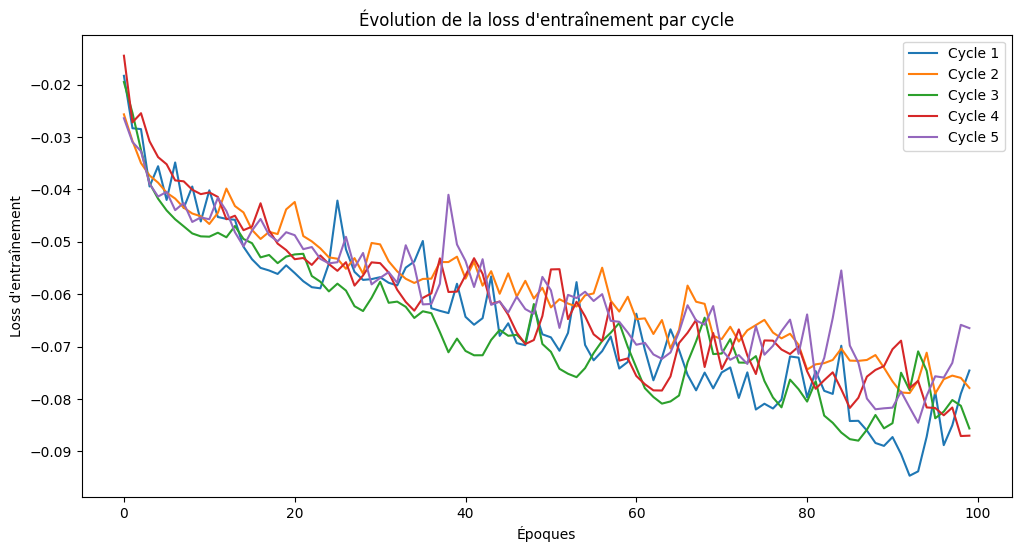

In [54]:
import matplotlib.pyplot as plt

# Plot de la training loss en fonction des epochs pour chaque cycle
plt.figure(figsize=(12, 6))
for i, train_losses in enumerate(train_losses_by_cycle):
    plt.plot(train_losses, label=f"Cycle {i+1}")
plt.xlabel("Époques")
plt.ylabel("Loss d'entraînement")
plt.title("Évolution de la loss d'entraînement par cycle")
plt.legend()
plt.show()

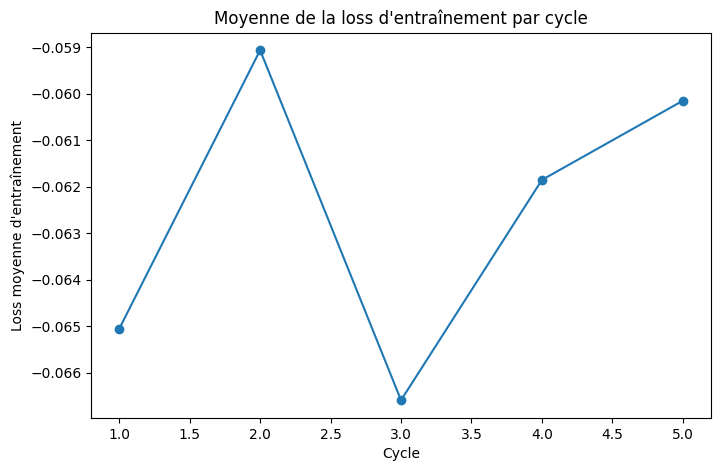

In [55]:
average_train_loss_by_cycle = [sum(train_losses) / len(train_losses) for train_losses in train_losses_by_cycle]
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(average_train_loss_by_cycle) + 1), average_train_loss_by_cycle, marker='o')
plt.xlabel("Cycle")
plt.ylabel("Loss moyenne d'entraînement")
plt.title("Moyenne de la loss d'entraînement par cycle")
plt.show()

In [56]:

dataframe_result = pd.DataFrame({
    'Date': pd.Series(dates_per_feature[idx_invest[0][0]:idx_invest[-1][1]]),
    'Return': pd.Series(rdt_all.numpy().flatten()),
    'Alloc_AGG': pd.Series(alloc_all[:, 0]),
    'Alloc_DBC': pd.Series(alloc_all[:, 1]),
    'Alloc_VTI': pd.Series(alloc_all[:, 2]),
    'Alloc_^VIX': pd.Series(alloc_all[:, 3])
})

dataframe_result['Date'] = pd.to_datetime(dataframe_result['Date'])
data_na['Date'] = pd.to_datetime(data_na['Date'])
dataframe_result = pd.merge(dataframe_result, data_na[['Date', 'AGG_y', 'DBC_y', 'VTI_y', '^VIX_y']], on='Date', how='left')

dataframe_result['Final_Return'] = (
    dataframe_result['Alloc_AGG'] * dataframe_result['AGG_y'] +
    dataframe_result['Alloc_DBC'] * dataframe_result['DBC_y'] +
    dataframe_result['Alloc_VTI'] * dataframe_result['VTI_y'] +
    dataframe_result['Alloc_^VIX'] * dataframe_result['^VIX_y']
)

dataframe_result

C:\Users\tahah\AppData\Local\Temp\ipykernel_35692\2977585624.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_na['Date'] = pd.to_datetime(data_na['Date'])


,Date,Return,Alloc_AGG,Alloc_DBC,Alloc_VTI,Alloc_^VIX,AGG_y,DBC_y,VTI_y,^VIX_y,Final_Return
0,2010-04-19,0.003517,0.464022,0.003702,0.509679,0.022597,0.001631,0.007936,0.009474,-0.092849,0.003517
1,2010-04-20,0.001489,0.482933,0.005983,0.483943,0.027141,0.001724,0.004973,-0.000809,0.037508,0.001489
2,2010-04-21,0.000481,0.660853,0.012806,0.282146,0.044195,-0.002008,0.002474,0.004858,0.009191,0.000481
3,2010-04-22,0.004937,0.246181,0.009074,0.683515,0.061230,-0.001245,0.006582,0.006769,0.009108,0.004937
4,2010-04-23,-0.001403,0.096776,0.003834,0.866599,0.032790,-0.000096,-0.004904,-0.003522,0.051143,-0.001403
...,...,...,...,...,...,...,...,...,...,...,...
2511,2020-04-08,0.014292,0.644662,0.001873,0.347485,0.005980,0.012434,0.002602,0.018713,-0.038754,0.014292
2512,2020-04-09,-0.007734,0.563470,0.003746,0.425657,0.007127,-0.004691,0.017301,-0.011912,-0.011999,-0.007734
2513,2020-04-13,0.009636,0.666852,0.002894,0.324002,0.006252,0.000514,-0.008504,0.030356,-0.082827,0.009636
2514,2020-04-14,-0.006084,0.594447,0.005151,0.391114,0.009288,0.004111,-0.020583,-0.023471,0.081568,-0.006084


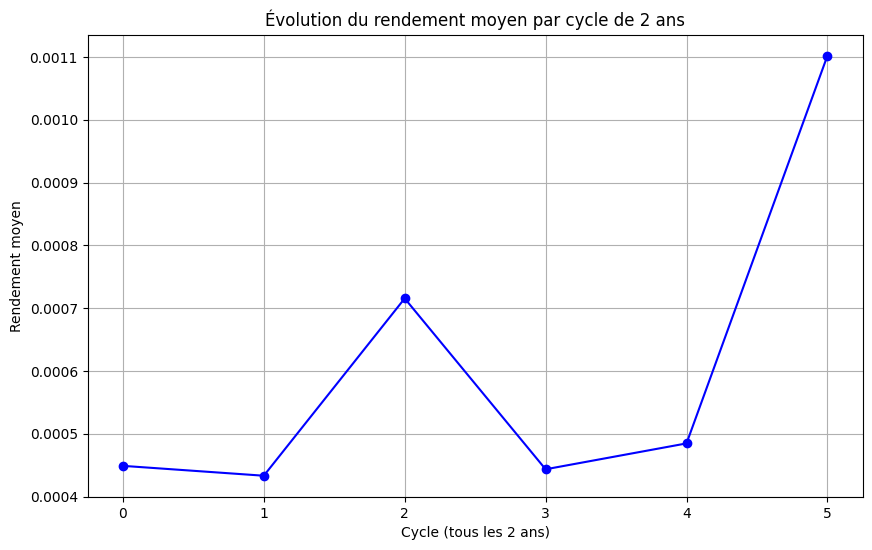

In [57]:
dataframe_result['Cycle'] = (dataframe_result['Date'].dt.year - dataframe_result['Date'].dt.year.min()) // 2

# rdmt moyen par cycle
mean_return_by_cycle = dataframe_result.groupby('Cycle')['Final_Return'].mean()

plt.figure(figsize=(10, 6))
plt.plot(mean_return_by_cycle.index, mean_return_by_cycle.values, marker='o', linestyle='-', color='b')
plt.xlabel("Cycle (tous les 2 ans)")
plt.ylabel("Rendement moyen")
plt.title("Évolution du rendement moyen par cycle de 2 ans")
plt.grid(True)
plt.show()

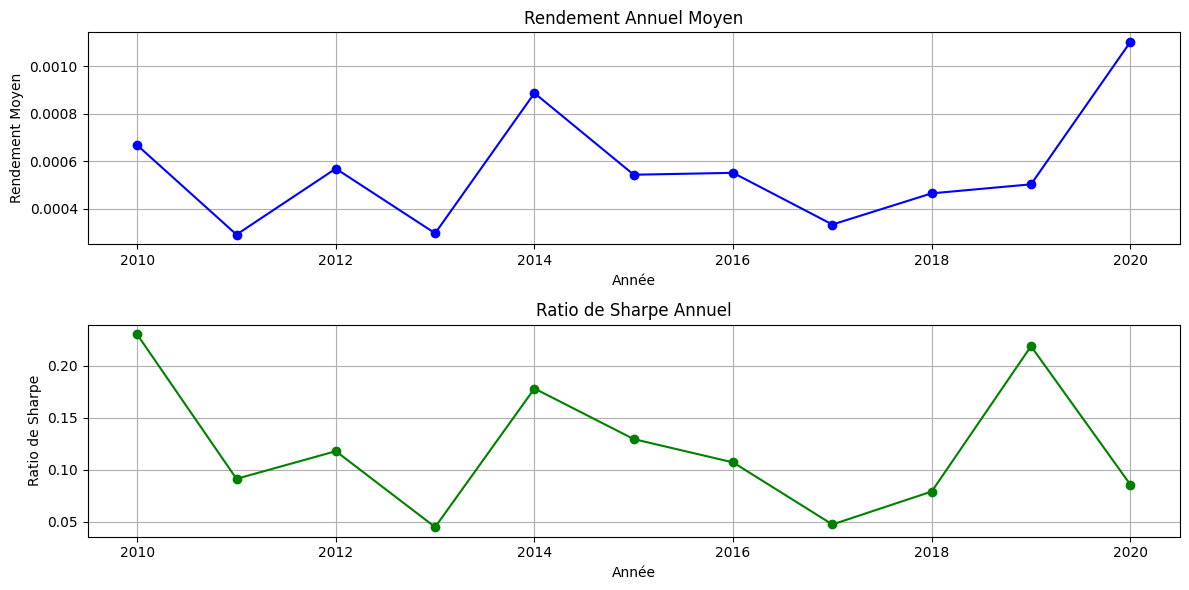

In [58]:
dataframe_result['Date'] = pd.to_datetime(dataframe_result['Date'])

dataframe_result['Year'] = dataframe_result['Date'].dt.year

annual_returns = dataframe_result.groupby('Year')['Final_Return'].mean()

# volatilité annuelle
annual_volatility = dataframe_result.groupby('Year')['Final_Return'].std()

# Sharpe annuel
sharpe_ratios = annual_returns / annual_volatility

annual_results = pd.DataFrame({
    'Annual Return': annual_returns,
    'Annual Volatility': annual_volatility,
    'Sharpe Ratio': sharpe_ratios
}).dropna() 

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(annual_results.index, annual_results['Annual Return'], marker='o', linestyle='-', color='b')
plt.title("Rendement Annuel Moyen")
plt.xlabel("Année")
plt.ylabel("Rendement Moyen")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(annual_results.index, annual_results['Sharpe Ratio'], marker='o', linestyle='-', color='g')
plt.title("Ratio de Sharpe Annuel")
plt.xlabel("Année")
plt.ylabel("Ratio de Sharpe")
plt.grid(True)

plt.tight_layout()
plt.show()


In [59]:
trading_days_per_year = 252

mean_daily_return = dataframe_result['Final_Return'].mean()
annualized_return = (1+mean_daily_return) ** trading_days_per_year -1

std_daily_return = dataframe_result['Final_Return'].std()
std_dd_return = dataframe_result[dataframe_result['Final_Return'] < 0]['Final_Return'].std()

annualized_volatility = std_daily_return * np.sqrt(trading_days_per_year)
annualized_volatility_dd = std_dd_return * np.sqrt(trading_days_per_year)

sharpe_ratio = annualized_return / annualized_volatility
sortino_ratio = annualized_return / annualized_volatility_dd

print(f"annualized mean return: {annualized_return:.4f}")
print(f"annualized std: {annualized_volatility:.4f}")
print(f"annualized dd: {annualized_volatility_dd:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Sortino Ratio: {sortino_ratio:.4f}")

annualized mean return: 0.1411
annualized std: 0.0852
annualized dd: 0.0581
Sharpe Ratio: 1.6561
Sortino Ratio: 2.4296


sharpe ratio va de 0.9 à 1.8 ??

# Volatilities 

In [38]:
def calculate_volatility(x_batches, decay=0.94):
    """
    Calculate the ex-ante volatility for each asset in each window in x_batches
    using an exponentially weighted moving standard deviation.
    
    Parameters:
    - x_batches: torch.Tensor of shape (num_windows, window_size, num_features)
    - decay: float, decay factor for exponential weighting (e.g., 0.94)
    
    Returns:
    - volatilities: torch.Tensor of shape (num_windows, num_assets)
    """
    # Extract only the return columns; x_batches has shape (num_windows, window_size=50, num_features=8)
    returns_batches = x_batches[:, :, :x_batches.shape[2] // 2]
    window_size = returns_batches.shape[1]
    num_assets = returns_batches.shape[2]
    
    weights = torch.tensor([decay ** i for i in range(window_size - 1, -1, -1)], dtype=torch.float32)
    weights /= weights.sum()  
    
    volatilities = []
    for window in returns_batches:
        window_tensor = torch.tensor(window, dtype=torch.float32)  # Convert `window` to a tensor
        weighted_returns = window_tensor * weights.view(-1, 1)  # Apply weights
        mean_weighted = weighted_returns.sum(dim=0)  # Weighted mean for each asset
        variance_weighted = ((window_tensor - mean_weighted) ** 2 * weights.view(-1, 1)).sum(dim=0)
        std_weighted = torch.sqrt(variance_weighted)
        volatilities.append(std_weighted)
    
    # Stack for all windows
    volatilities = torch.stack(volatilities)
    return volatilities  # We have the volatilities at the final date for each 50-day window


In [39]:
def investing_scaled(x_batches, y, model, volatilities, target_volatility=0.1, cost_rate=0.0001): 
    """
    Calculates the portfolio returns using model allocations, adjusted by volatility scaling and transaction costs.

    Parameters:
    - x_batches: np.array, shape (num_batches, window_size, input_size), input data (returns and prices).
    - y: np.array, shape (num_batches, 1, num_assets), target returns for each day in the investing period.
    - model: trained model for generating portfolio allocations.
    - volatilities: np.array, shape (num_batches, num_assets), ex-ante volatilities for each asset.
    - target_volatility: float, target volatility level.
    - cost_rate: float, transaction cost rate.

    Returns:
    - portfolio_returns: Tensor, shape (num_batches, 1), calculated portfolio returns.
    - allocations: Tensor, shape (num_batches, num_assets), model's allocations for each asset.
    """
    x_tensor = torch.tensor(x_batches, dtype=torch.float32)
    allocations = model.get_allocations(x_tensor)  # Shape: (num_batches, num_assets)

    allocations = allocations.view(allocations.shape[0], 1, allocations.shape[1])
    
    volatilities = torch.tensor(volatilities, dtype=torch.float32)
    
    scaling_factor = target_volatility / volatilities  # Shape: (num_batches, num_assets)
    scaled_allocations = allocations * scaling_factor.unsqueeze(1) 

    # on décale de 1 à la prem dimension car c celle du temps 
    transaction_costs = cost_rate * torch.sum(torch.abs(scaled_allocations[1:] - scaled_allocations[:-1]), dim=2)


    portfolio_returns = torch.sum(scaled_allocations * y, dim=2)
    portfolio_returns[1:] -= transaction_costs  # Apply transaction costs from the second time step onward

    return portfolio_returns, scaled_allocations


In [40]:
input_size = 8
hidden_size = 64
output_size = 4
batch_size = 64

rdt_all = torch.empty(0,0)
alloc_all = []
idx_invest = []
dates_invest = []

# first training goes from 2006 to 2010
first_date = dates_per_feature[0]
end_date_1st_training = first_date + datetime.timedelta(days=365*4)

# trouve le premier batch et le dernier batch correspondant
idx_start, idx_end = get_idx_dates(first_date, end_date_1st_training)

model = PortfolioRNN(input_size=input_size, hidden_size=hidden_size, num_layers = 2,output_size=output_size)


model, _ = training(x_batches = x_batches[idx_start:idx_end, :, :],
                      y_batches= y_batches[idx_start:idx_end, :, :],
                      model=model,
                      batch_size=64)

# un an c pas 365 jours mais 252 jours de trading
date_end_invest = end_date_1st_training + datetime.timedelta(days=365*2)
idx_start_invest, idx_end_invest = get_idx_dates(end_date_1st_training, date_end_invest)

print(f"Idx start: {idx_start_invest}, Idx end: {idx_end_invest}")
print(dates_per_feature[idx_start_invest], dates_per_feature[idx_end_invest])

idx_invest.append((idx_start_invest, idx_end_invest))
dates_invest.append((end_date_1st_training, date_end_invest))

x_investing = x_batches[idx_start_invest:idx_end_invest, :, :]
y_investing = y_batches[idx_start_invest:idx_end_invest, :, :]
y_real = y[idx_start_invest:idx_end_invest, :, :]

#calcul des volatilités
volatilities = calculate_volatility(x_batches=x_investing)

first_rdt, first_alloc = investing_scaled(x_batches= x_investing, y=y_real, volatilities=volatilities, model=model)

print(first_rdt.shape, len(dates_per_feature[idx_start_invest:idx_end_invest]))

print(f"first_rdt shape: {first_rdt.shape}, rdt_all shape before concat: {rdt_all.shape}")



epoch [1/100], loss: -0.016510694549651816
epoch [2/100], loss: -0.029217440678621642
epoch [3/100], loss: -0.029682886379305273
epoch [4/100], loss: -0.036988533076510066
epoch [5/100], loss: -0.0362657574005425
epoch [6/100], loss: -0.041417496191570535
epoch [7/100], loss: -0.03617673180997372
epoch [8/100], loss: -0.04190868398291059
epoch [9/100], loss: -0.03958419704576954
epoch [10/100], loss: -0.0437385224213358
epoch [11/100], loss: -0.04361053902175627
epoch [12/100], loss: -0.04873572351061739
epoch [13/100], loss: -0.04517405641308869
epoch [14/100], loss: -0.04895370904705487
epoch [15/100], loss: -0.04797953768866137
epoch [16/100], loss: -0.040771464991848916
epoch [17/100], loss: -0.054288381046717404
epoch [18/100], loss: -0.044753585920261685
epoch [19/100], loss: -0.04506566129566636
epoch [20/100], loss: -0.04197007554466836
epoch [21/100], loss: -0.05334535446672817
epoch [22/100], loss: -0.04973264748696238
epoch [23/100], loss: -0.05139070429140702
epoch [24/100]

C:\Users\tahah\AppData\Local\Temp\ipykernel_35692\3173161383.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  volatilities = torch.tensor(volatilities, dtype=torch.float32)


In [41]:

rdt_all = first_rdt
alloc_all = first_alloc

#entrainement sur 5 cycles Cycle 1 :
#Période d’entraînement : 2006 à 2010.
#Période d’investissement : 2010 à 2012.
#Cycle 2 :
#La date de fin d’entraînement est avancée jusqu'en 2012 (couvrant 2006-2012).
#La nouvelle période d’investissement couvre alors 2012 à 2014.
#etc jusqu'au cycle 5 
#rdt_all/alloc_all contient les rendements/alloc sur toute la période 

train_losses_by_cycle = []

#change tp 4
for i in range(5):

    model, train_losses  = training(x_batches = x_batches[idx_start_invest:idx_end_invest, :, :],
                      y_batches= y_batches[idx_start_invest:idx_end_invest, :, :],
                      model=model,
                      batch_size=64)
    train_losses_by_cycle.append(train_losses)
    
    date_end_invest = date_end_invest + datetime.timedelta(days=365*2)
    end_date_1st_training = end_date_1st_training + datetime.timedelta(days=365*2)
    idx_start_invest, idx_end_invest = get_idx_dates(end_date_1st_training, date_end_invest)

    x_investing = x_batches[idx_start_invest:idx_end_invest, :, :]
    y_investing = y_batches[idx_start_invest:idx_end_invest, :, :]
    y_real = y[idx_start_invest:idx_end_invest, :, :]

    #calcul des volatilités
    volatilities = calculate_volatility(x_batches=x_investing)

    first_rdt, first_alloc = investing_scaled(x_batches= x_investing, y=y_real, volatilities=volatilities, model=model)

    print(first_rdt.shape, len(dates_per_feature[idx_start_invest:idx_end_invest]))


    rdt_all = torch.cat([rdt_all, first_rdt], dim=0)
    print('len des rdt', rdt_all.shape[0])
    alloc_all = torch.cat([alloc_all, first_alloc], dim=0)
    idx_invest.append((idx_start_invest, idx_end_invest))
    print('len des dates', len(dates_per_feature[idx_invest[0][0]:idx_invest[-1][1]]))
    dates_invest.append((end_date_1st_training, date_end_invest))


alloc_all = alloc_all.numpy()
alloc_all = alloc_all.reshape(alloc_all.shape[0], alloc_all.shape[2])

epoch [1/100], loss: -0.03096044948324561
epoch [2/100], loss: -0.03758958145044744
epoch [3/100], loss: -0.03950437321327627
epoch [4/100], loss: -0.04138003080151975
epoch [5/100], loss: -0.04283494921401143
epoch [6/100], loss: -0.04416472464799881
epoch [7/100], loss: -0.046839240938425064
epoch [8/100], loss: -0.04734047525562346
epoch [9/100], loss: -0.04759005177766085
epoch [10/100], loss: -0.04872967046685517
epoch [11/100], loss: -0.049798415740951896
epoch [12/100], loss: -0.04856251995079219
epoch [13/100], loss: -0.049260206054896116
epoch [14/100], loss: -0.05186886200681329
epoch [15/100], loss: -0.053168614860624075
epoch [16/100], loss: -0.051508582197129726
epoch [17/100], loss: -0.05293681751936674
epoch [18/100], loss: -0.05292146699503064
epoch [19/100], loss: -0.055009095929563046
epoch [20/100], loss: -0.05200578086078167
epoch [21/100], loss: -0.052479584235697985
epoch [22/100], loss: -0.057038997299969196
epoch [23/100], loss: -0.05605814326554537
epoch [24/10

C:\Users\tahah\AppData\Local\Temp\ipykernel_35692\3173161383.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  volatilities = torch.tensor(volatilities, dtype=torch.float32)


torch.Size([503, 1]) 503
len des rdt 1008
len des dates 1008
epoch [1/100], loss: -0.021715391194447875
epoch [2/100], loss: -0.0293787878472358
epoch [3/100], loss: -0.03081489313626662
epoch [4/100], loss: -0.034670458117034286
epoch [5/100], loss: -0.03698131605051458
epoch [6/100], loss: -0.039100095396861434
epoch [7/100], loss: -0.039796712109819055
epoch [8/100], loss: -0.04159780987538397
epoch [9/100], loss: -0.04197994340211153
epoch [10/100], loss: -0.0420070921536535
epoch [11/100], loss: -0.04174358397722244
epoch [12/100], loss: -0.044551689410582185
epoch [13/100], loss: -0.04631449142470956
epoch [14/100], loss: -0.04748885869048536
epoch [15/100], loss: -0.04818835319019854
epoch [16/100], loss: -0.047518966253846884
epoch [17/100], loss: -0.04717524070292711
epoch [18/100], loss: -0.04781872872263193
epoch [19/100], loss: -0.0483986078761518
epoch [20/100], loss: -0.04955798666924238
epoch [21/100], loss: -0.04832185339182615
epoch [22/100], loss: -0.05212832777760923

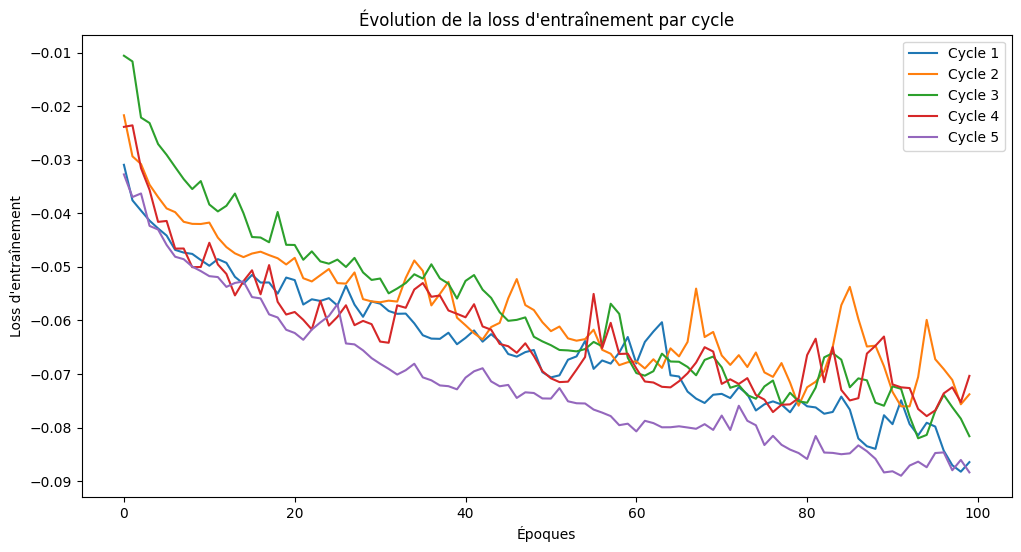

In [42]:
import matplotlib.pyplot as plt

# Plot de la training loss en fonction des epochs pour chaque cycle
plt.figure(figsize=(12, 6))
for i, train_losses in enumerate(train_losses_by_cycle):
    plt.plot(train_losses, label=f"Cycle {i+1}")
plt.xlabel("Époques")
plt.ylabel("Loss d'entraînement")
plt.title("Évolution de la loss d'entraînement par cycle")
plt.legend()
plt.show()

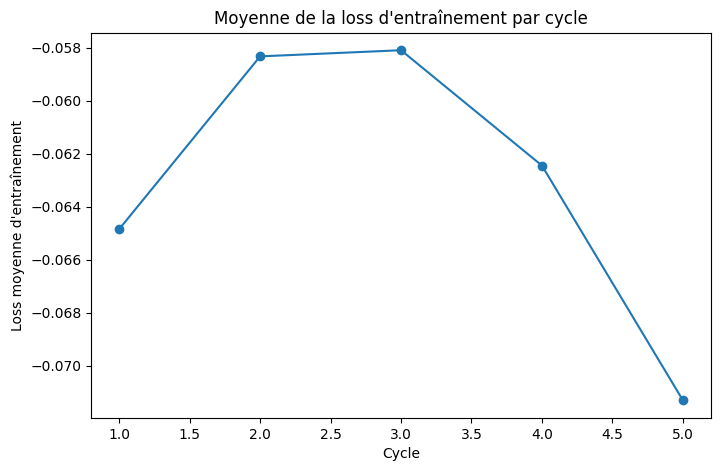

In [43]:
average_train_loss_by_cycle = [sum(train_losses) / len(train_losses) for train_losses in train_losses_by_cycle]
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(average_train_loss_by_cycle) + 1), average_train_loss_by_cycle, marker='o')
plt.xlabel("Cycle")
plt.ylabel("Loss moyenne d'entraînement")
plt.title("Moyenne de la loss d'entraînement par cycle")
plt.show()

In [44]:

dataframe_result = pd.DataFrame({
    'Date': pd.Series(dates_per_feature[idx_invest[0][0]:idx_invest[-1][1]]),
    'Return': pd.Series(rdt_all.numpy().flatten()),
    'Alloc_AGG': pd.Series(alloc_all[:, 0]),
    'Alloc_DBC': pd.Series(alloc_all[:, 1]),
    'Alloc_VTI': pd.Series(alloc_all[:, 2]),
    'Alloc_^VIX': pd.Series(alloc_all[:, 3])
})

dataframe_result['Date'] = pd.to_datetime(dataframe_result['Date'])
data_na['Date'] = pd.to_datetime(data_na['Date'])
dataframe_result = pd.merge(dataframe_result, data_na[['Date', 'AGG_y', 'DBC_y', 'VTI_y', '^VIX_y']], on='Date', how='left')

dataframe_result['Final_Return'] = (
    dataframe_result['Alloc_AGG'] * dataframe_result['AGG_y'] +
    dataframe_result['Alloc_DBC'] * dataframe_result['DBC_y'] +
    dataframe_result['Alloc_VTI'] * dataframe_result['VTI_y'] +
    dataframe_result['Alloc_^VIX'] * dataframe_result['^VIX_y']
)

dataframe_result

C:\Users\tahah\AppData\Local\Temp\ipykernel_35692\2977585624.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_na['Date'] = pd.to_datetime(data_na['Date'])


,Date,Return,Alloc_AGG,Alloc_DBC,Alloc_VTI,Alloc_^VIX,AGG_y,DBC_y,VTI_y,^VIX_y,Final_Return
0,2010-04-19,0.099779,19.401499,0.084089,7.818878,0.071217,0.001631,0.007936,0.009474,-0.092849,0.099779
1,2010-04-20,0.039139,24.744513,0.096575,6.749704,0.056015,0.001724,0.004973,-0.000809,0.037508,0.039782
2,2010-04-21,-0.045315,32.403450,0.100818,4.043519,0.098670,-0.002008,0.002474,0.004858,0.009191,-0.044274
3,2010-04-22,0.070847,6.775777,0.124207,11.873876,0.159122,-0.001245,0.006582,0.006769,0.009108,0.074202
4,2010-04-23,-0.045939,2.465610,0.063150,14.213493,0.104476,-0.000096,-0.004904,-0.003522,0.051143,-0.045263
...,...,...,...,...,...,...,...,...,...,...,...
2690,2020-12-22,-0.039702,58.729824,0.001145,0.696294,0.002593,-0.000678,0.012517,0.001710,-0.037969,-0.038736
2691,2020-12-23,0.056793,60.721470,0.002285,0.427091,0.005050,0.000934,0.002747,0.001673,-0.076362,0.057020
2692,2020-12-24,0.035696,38.902248,0.010768,4.997426,0.024857,0.000169,-0.006164,0.006327,0.007896,0.038338
2693,2020-12-28,0.004009,59.740154,0.001526,1.129218,0.016794,0.000169,0.002757,-0.004174,0.063594,0.006481


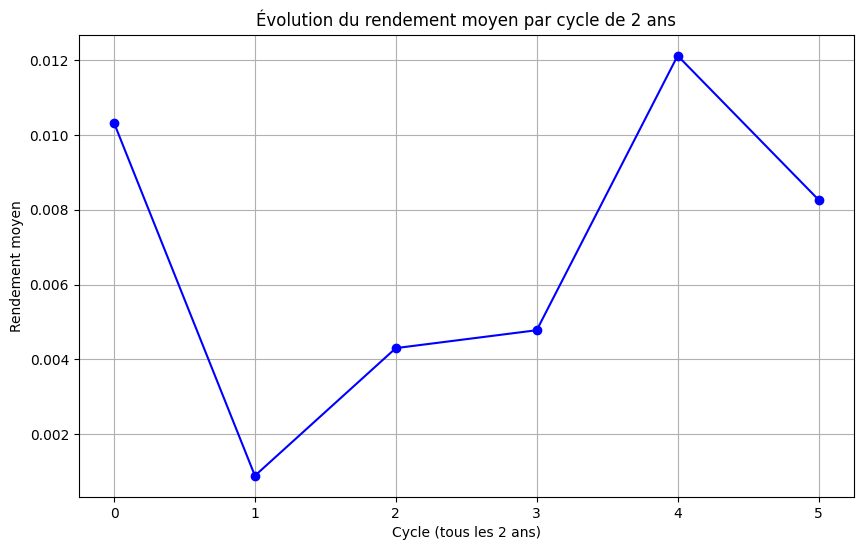

In [45]:
dataframe_result['Cycle'] = (dataframe_result['Date'].dt.year - dataframe_result['Date'].dt.year.min()) // 2

# rdmt moyen par cycle
mean_return_by_cycle = dataframe_result.groupby('Cycle')['Final_Return'].mean()

plt.figure(figsize=(10, 6))
plt.plot(mean_return_by_cycle.index, mean_return_by_cycle.values, marker='o', linestyle='-', color='b')
plt.xlabel("Cycle (tous les 2 ans)")
plt.ylabel("Rendement moyen")
plt.title("Évolution du rendement moyen par cycle de 2 ans")
plt.grid(True)
plt.show()

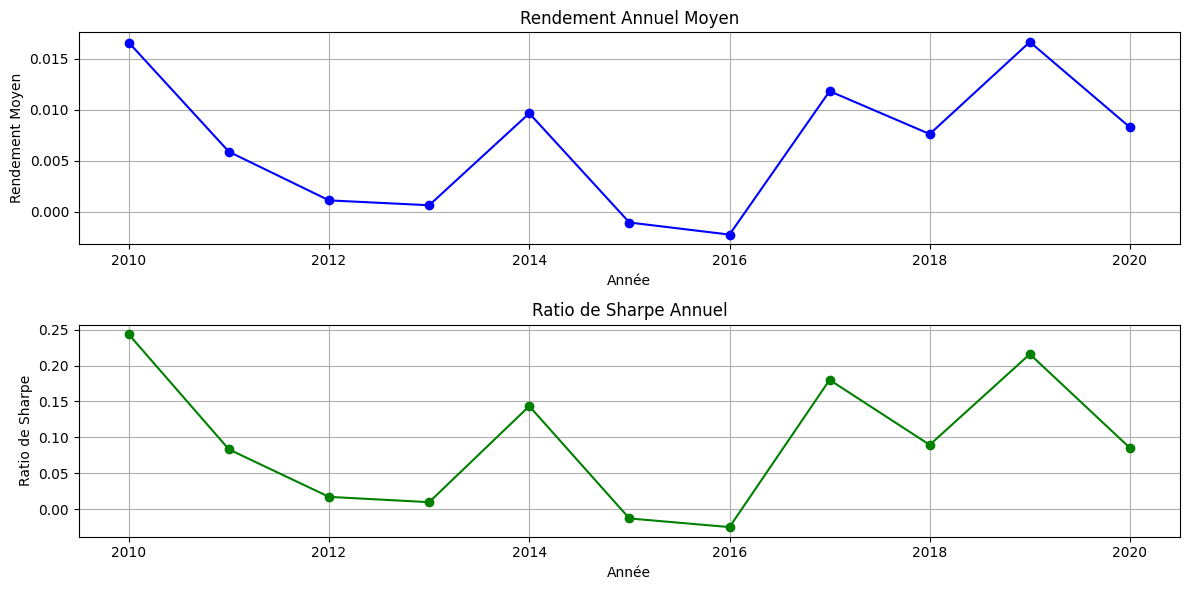

In [46]:
dataframe_result['Date'] = pd.to_datetime(dataframe_result['Date'])

dataframe_result['Year'] = dataframe_result['Date'].dt.year

annual_returns = dataframe_result.groupby('Year')['Final_Return'].mean()

# volatilité annuelle
annual_volatility = dataframe_result.groupby('Year')['Final_Return'].std()

# Sharpe annuel
sharpe_ratios = annual_returns / annual_volatility

annual_results = pd.DataFrame({
    'Annual Return': annual_returns,
    'Annual Volatility': annual_volatility,
    'Sharpe Ratio': sharpe_ratios
}).dropna() 

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(annual_results.index, annual_results['Annual Return'], marker='o', linestyle='-', color='b')
plt.title("Rendement Annuel Moyen")
plt.xlabel("Année")
plt.ylabel("Rendement Moyen")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(annual_results.index, annual_results['Sharpe Ratio'], marker='o', linestyle='-', color='g')
plt.title("Ratio de Sharpe Annuel")
plt.xlabel("Année")
plt.ylabel("Ratio de Sharpe")
plt.grid(True)

plt.tight_layout()
plt.show()

In [47]:
trading_days_per_year = 252

mean_daily_return = dataframe_result['Final_Return'].mean()
annualized_return = (1+mean_daily_return) ** trading_days_per_year -1

std_daily_return = dataframe_result['Final_Return'].std()
std_dd_return = dataframe_result[dataframe_result['Final_Return'] < 0]['Final_Return'].std()

annualized_volatility = std_daily_return * np.sqrt(trading_days_per_year)
annualized_volatility_dd = std_dd_return * np.sqrt(trading_days_per_year)

sharpe_ratio = annualized_return / annualized_volatility
sortino_ratio = annualized_return / annualized_volatility_dd

print(f"annualized mean return: {annualized_return:.4f}")
print(f"annualized std: {annualized_volatility:.4f}")
print(f"annualized dd: {annualized_volatility_dd:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Sortino Ratio: {sortino_ratio:.4f}")

annualized mean return: 4.1802
annualized std: 1.2166
annualized dd: 0.9107
Sharpe Ratio: 3.4358
Sortino Ratio: 4.5900
